## Quick look production data analysis for Vaca Muerta basin based on open source data

#### This notebook works wih open source data from provided by Argentina government on their website. The script gets data merges two spreadsheets (one with prodcution and another with completion data), looks for the needed data, calculates some additional variables and provides some plotting - rate v time, qumulative oil prod vs time, normalized oil rate vs time, distribution of maximum oil rate (as initial oil rate might not be representative because of choke managment), maximum oil rate normalized to 100 m of lateral lentgh and per 1 stage of hydraulic fracture and distribution of GOR.

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
def prod_analysis(file_prod, file_comp, wells, LL, NS):
    """
    This function is intended to analyze production data for Nequen basin based on the input well list chosen with respect to proximity of the evaluated asset
    
    file_prod - input production data by well from Agrentina Energy Ministry website
    file_comp - input production data by well from Agrentina Energy Ministry website
    wells - list of the wells in the form of 'idpozo'
    LL - additional filtering criteria for lateral length. Set 0 if not needed
    NS - additional filtering criteria for number of stages. Set 0 if not needed
    """

    np.seterr(all='ignore')

    #Loading production and completion data
    completion_data = pd.read_csv(file_prod)
    prod_data = pd.read_csv(file_comp)

    #Joining two tables into a single dataframe
    df = prod_data.join(completion_data.set_index('idpozo'), on='idpozo',lsuffix='_left', rsuffix='_right')
    df.dropna(axis=0, how='any', subset=['longitud_rama_horizontal_m',
                                            'cantidad_fracturas',
                                            'tipo_terminacion',
                                            'arena_bombeada_nacional_tn',
                                            'arena_bombeada_importada_tn',
                                            'agua_inyectada_m3',
                                            'co2_inyectado_m3'])
    
    #Keeping only wells producing from Vaca Muerta
    df_VM = df[(df['formprod'] == 'VMUT')]
    df_VM.drop(['mes_right',
                'sigla_right',
                'areapermisoconcesion_right',
                'fecha_data_right'], axis = 1, inplace=True)
    df_VM.reset_index(inplace=True)

    #Keeping only wells with completion information
    df_VM.dropna(subset =['id_base_fractura_adjiv'], inplace=True)
    
    #Keeping only horizontal wells
    df_VM_Hz = df_VM[(df_VM['longitud_rama_horizontal_m'] > 100)]

    #Getting a dataframe with only wellhed for mapping
    df_VM_Hz_Map = df_VM_Hz.copy()
    df_VM_Hz_Map.drop_duplicates(subset=['idpozo'], inplace=True)
    df_VM_Hz_Map.head()
    df_VM_Hz_Map.to_csv('Data\VM_wells_to_map.txt', sep='\t')


    #Keeping only chosen wells based on the proximity to the asset under evaluation and optinally setting additional cut-offs on lateral length and number of stages
    df_VM_Hz_ADC = df_VM_Hz[(df_VM_Hz['idpozo'].isin(wells)) & (df_VM_Hz['longitud_rama_horizontal_m']>LL) & (df_VM_Hz['cantidad_fracturas']>NS)]
    df_VM_Hz_ADC.sort_values(by=['idpozo', 'anio', 'mes_left' ], inplace=True)
    df_VM_Hz_ADC.reset_index(inplace=True)
    
    #Building a clean dataframe for plotting and analysis
    df_plot = pd.DataFrame({'Well_ID':[],
                            'Well':[],
                            'Time, month':[],
                            'Oil production, m3/d':[],
                            'Oil production norm':[],
                            'Gas production, 1000m3/d':[],
                            'Water production, m3/d':[],
                            'Lhor, m':[],
                            'Nstages':[],
                            'Sand pumped, tn':[],
                            'Cumulative oil production, m3':[],
                            'EUR, m3': []})


    counter = -1
    for i in ADC_wells:
        tef = 0
        cum = 0
        df_rr = df[(df['idpozo'] == i)]
        max_oil_rate = df_rr['prod_pet'].max()
        eur = df_rr['prod_pet'].sum()
    
        for j in range(df_VM_Hz_ADC.shape[0]):
            counter +=1
            if df_VM_Hz_ADC.loc[j, 'idpozo'] == i:
                tef = tef + df_VM_Hz_ADC.loc[j, 'tef']/30
                cum = cum + df_VM_Hz_ADC.loc[j, 'prod_pet']
                df_plot.at[counter, 'Well_ID'] = df_VM_Hz_ADC.loc[j, 'sigla_left']
                df_plot.at[counter, 'Well'] = i
                df_plot.at[counter, 'Time, month'] = tef
                df_plot.at[counter, 'Oil production, m3/d']=df_VM_Hz_ADC.loc[j, 'prod_pet']/df_VM_Hz_ADC.loc[j, 'tef']
                df_plot.at[counter, 'Oil production norm'] = df_VM_Hz_ADC.loc[j, 'prod_pet']/ max_oil_rate
                df_plot.at[counter, 'Gas production, 1000m3/d'] = df_VM_Hz_ADC.loc[j, 'prod_gas']/df_VM_Hz_ADC.loc[j, 'tef']
                df_plot.at[counter, 'Water production, m3/d'] = df_VM_Hz_ADC.loc[j, 'prod_agua']/df_VM_Hz_ADC.loc[j, 'tef']
                df_plot.at[counter, 'Lhor, m'] = df_VM_Hz_ADC.loc[j, 'longitud_rama_horizontal_m']
                df_plot.at[counter, 'Nstages'] = df_VM_Hz_ADC.loc[j, 'cantidad_fracturas']
                df_plot.at[counter, 'Sand pumped, tn'] = df_VM_Hz_ADC.loc[j, 'arena_bombeada_nacional_tn'] + df_VM_Hz_ADC.loc[j, 'arena_bombeada_importada_tn']  
                df_plot.at[counter, 'Cumulative oil production, m3'] = cum
                df_plot.at[counter, 'EUR, m3'] = eur
            else:
                continue

    #Calculating additional variables
    df_plot['GOR instantaneous, m3/m3'] = df_plot['Gas production, 1000m3/d']/df_plot['Oil production, m3/d']*1000
    df_plot['WC, %'] = df_plot['Water production, m3/d']/(df_plot['Oil production, m3/d'] + df_plot['Water production, m3/d'])*100
    df_plot['Sand per stage, tn'] = df_plot['Sand pumped, tn']/df_plot['Nstages']
    df_plot['Oil rate per Lhor per stage, m3/d/100m/stage'] = df_plot['Oil production, m3/d']/df_plot['Nstages']/df_plot['Lhor, m']*100
    df_plot['EUR_designed m3'] = df_plot['EUR, m3']/df_plot['Lhor, m']/df_plot['Nstages']


    #Plotting section
    plt.figure(figsize=(25.0,20.0))

    #Plotting oil rate vs time
    sns.set_context("paper", font_scale=0.9) 
    sns.lineplot(data=df_plot, x='Time, month', y='Oil production, m3/d', hue='Well_ID', palette = 'icefire', legend='full')
    plt.savefig('Oil rate vs time.png')

    #Plotting cumulative oil production vs time
    plt.figure(figsize=(25.0,20.0))
    sns.set_context("paper", font_scale=0.9) 
    sns.lineplot(data=df_plot, x='Time, month', y='Cumulative oil production, m3', hue='Well_ID', palette = 'icefire', legend='full')
    plt.savefig('Cumulative oil production vs time.png')

    #Plotting normalized oil rate vs time
    plt.figure(figsize=(25.0,20.0))
    sns.set_context("paper", font_scale=0.9) 
    sns.lineplot(data=df_plot, x='Time, month', y='Oil production norm', hue='Well_ID', palette = 'icefire', legend='full')
    plt.savefig('Normalized oil rate vs time.png')

    #Plotting maximum oil rate histogram
    grouped = df_plot.groupby(['Well_ID'])
    plt.figure(figsize=(15.0,12.0))
    plt.hist(grouped['Oil production, m3/d'].max(),10, edgecolor='black')
    plt.xlabel('Максимальный дебит нефти, m3/d')
    plt.savefig('Maximum oil rate distribution.png')
    stat_oil_rate = grouped['Oil production, m3/d'].max().quantile(q=np.linspace(0,1,11)) 
    
    #Plotting maximum oil rate per lateral length per number of tages histogram
    plt.figure(figsize=(15.0,12.0))
    plt.hist(grouped['Oil rate per Lhor per stage, m3/d/100m/stage'].max(),10, edgecolor='black')
    plt.xlabel('Максимальный приведенный дебит нефти на 100 м ГС на 1 стадию ГРП, m3/d')
    plt.savefig('Normalized oil rate distribution.png')
    stat_norm_rate = grouped['Oil rate per Lhor per stage, m3/d/100m/stage'].max().quantile(q=np.linspace(0,1,11))
    
    #Plotting mean gas-oil ration
    plt.figure(figsize=(15.0,12.0))
    plt.hist(grouped['GOR instantaneous, m3/m3'].mean(),10, range=(0,1000), edgecolor='black')
    plt.xlabel('Средний ГФ, m3/m3')
    plt.savefig('Mean GOR.png')
    stat_GOR = grouped['GOR instantaneous, m3/m3'].mean().quantile(q=np.linspace(0,1,11))
    return stat_oil_rate, stat_norm_rate, stat_GOR, df_plot


(0.0     26.464839
 0.1     35.934107
 0.2     55.224438
 0.3     82.095617
 0.4    105.376597
 0.5    111.223830
 0.6    120.672008
 0.7    131.022976
 0.8    141.926937
 0.9    167.100245
 1.0    194.215000
 Name: Oil production, m3/d, dtype: float64,
 0.0    0.113854
 0.1    0.165198
 0.2    0.193479
 0.3    0.202654
 0.4    0.206195
 0.5    0.230704
 0.6    0.279175
 0.7    0.305042
 0.8    0.426501
 0.9    0.604613
 1.0    5.314591
 Name: Oil rate per Lhor per stage, m3/d/100m/stage, dtype: float64,
 0.0     54.401128
 0.1     60.298542
 0.2     77.928523
 0.3    111.502867
 0.4    129.704295
 0.5    144.396383
 0.6    156.229033
 0.7    234.448926
 0.8    253.617561
 0.9    423.138993
 1.0           NaN
 Name: GOR instantaneous, m3/m3, dtype: float64,
                     Well_ID      Well  Time, month  Oil production, m3/d  \
 293       YPF.Nq.LACh-22(h)  156968.0     0.707667             18.365520   
 294       YPF.Nq.LACh-22(h)  156968.0     1.596000             70.003752   
 

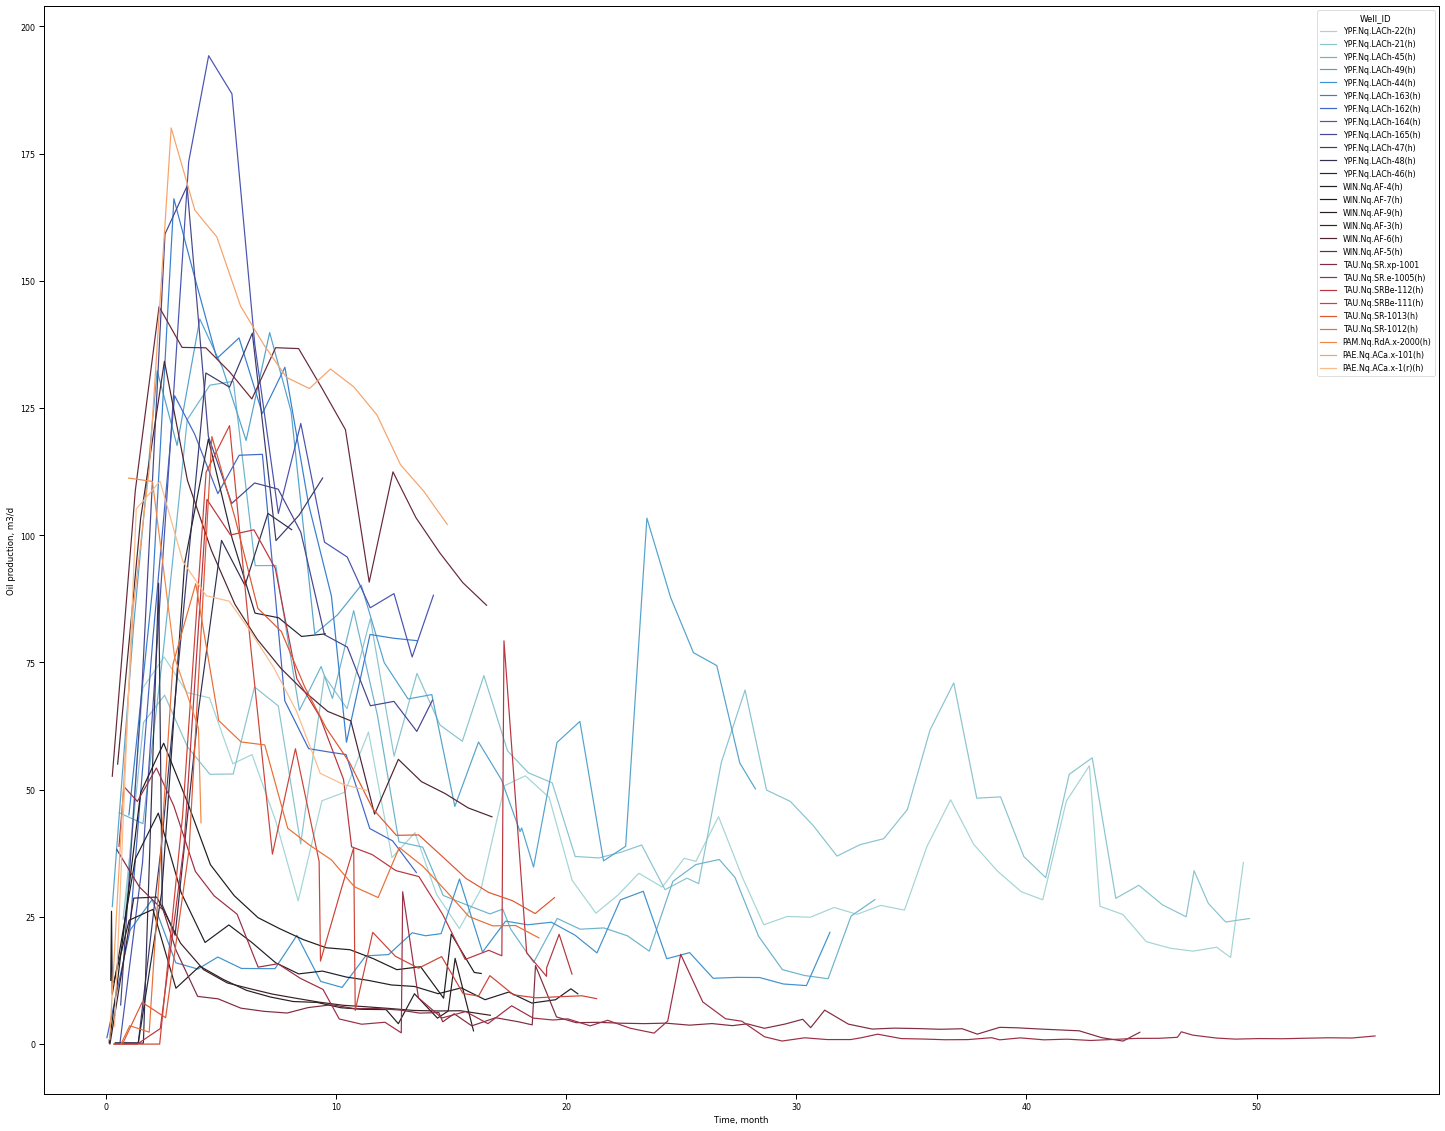

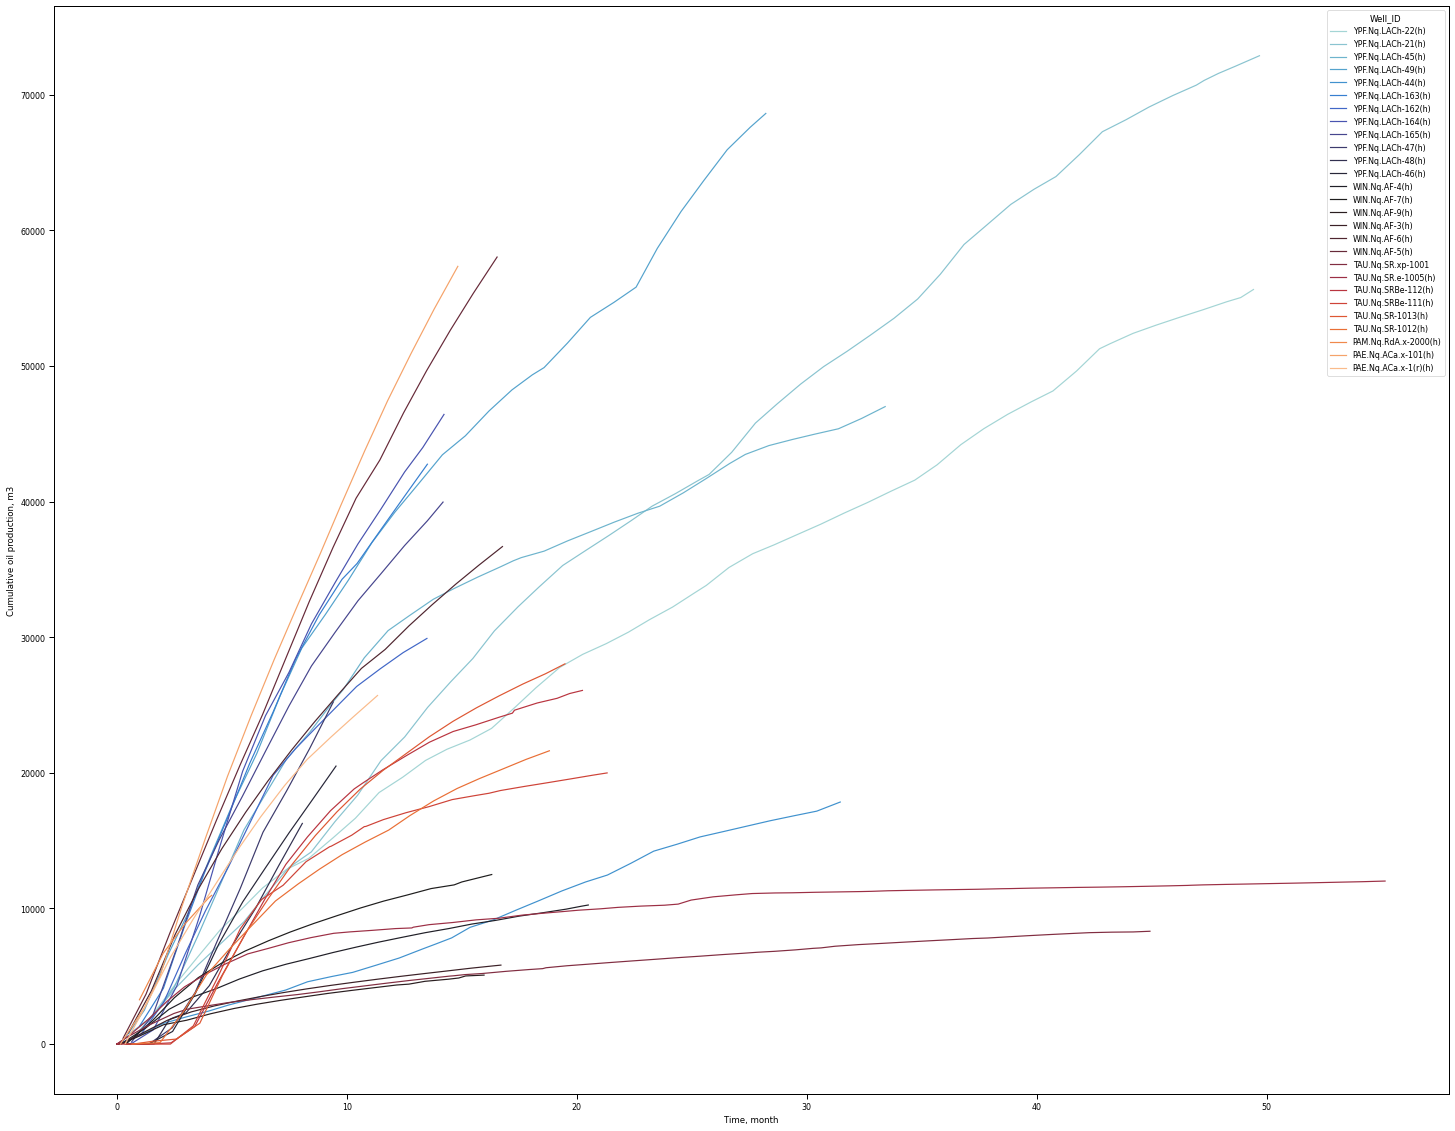

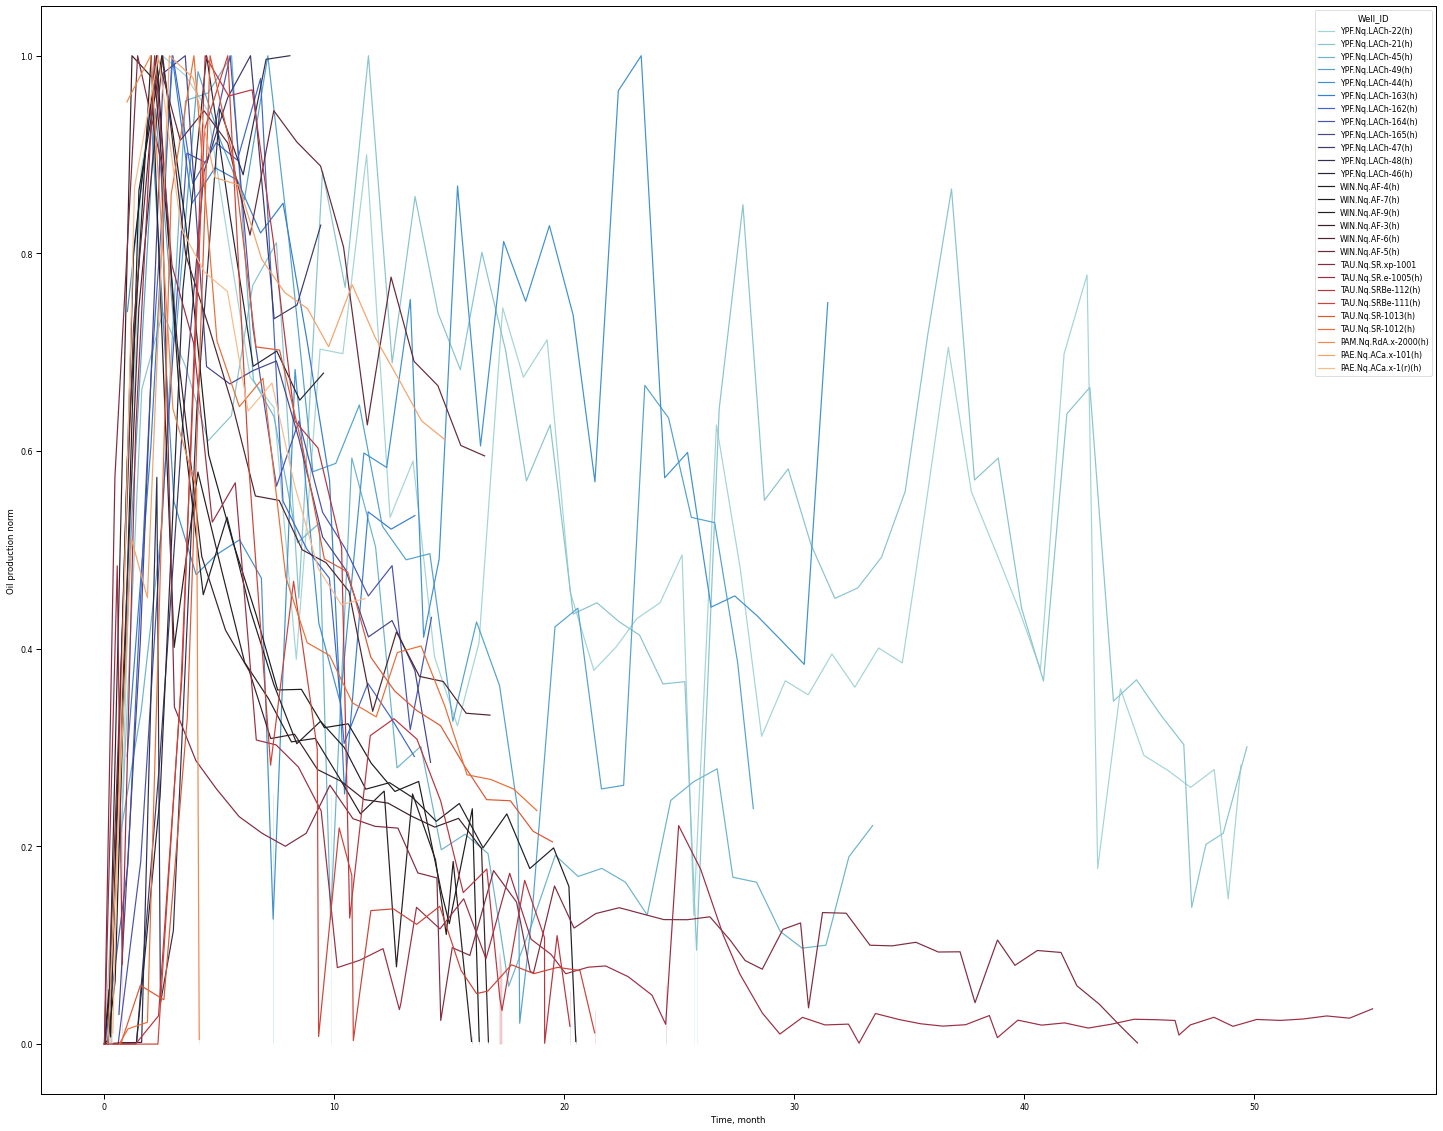

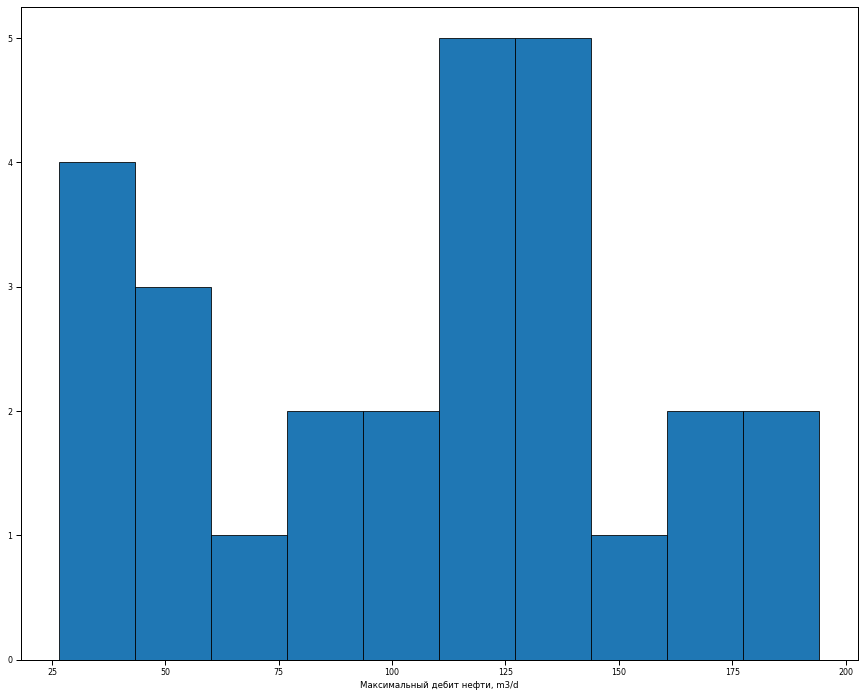

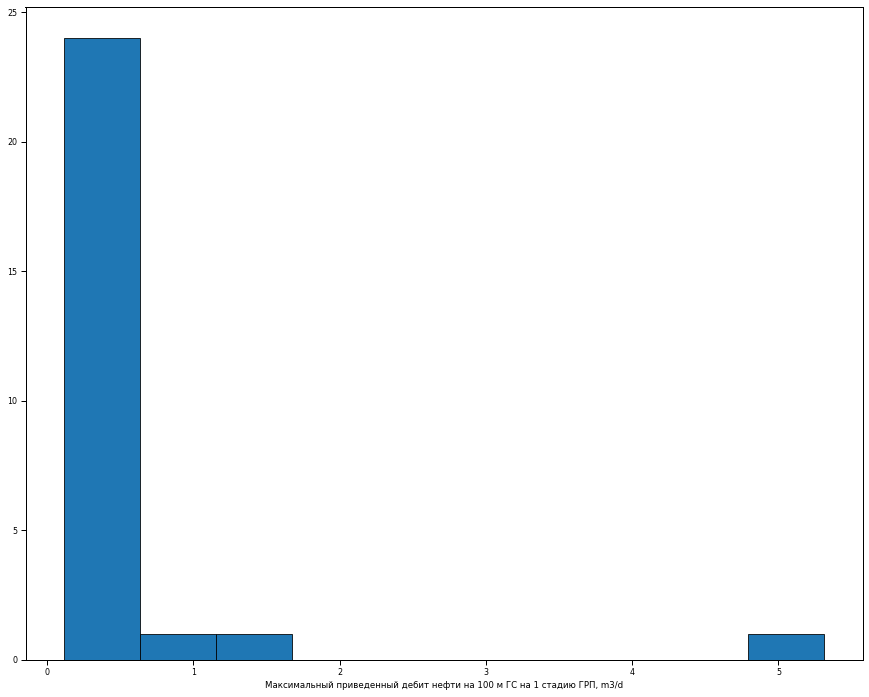

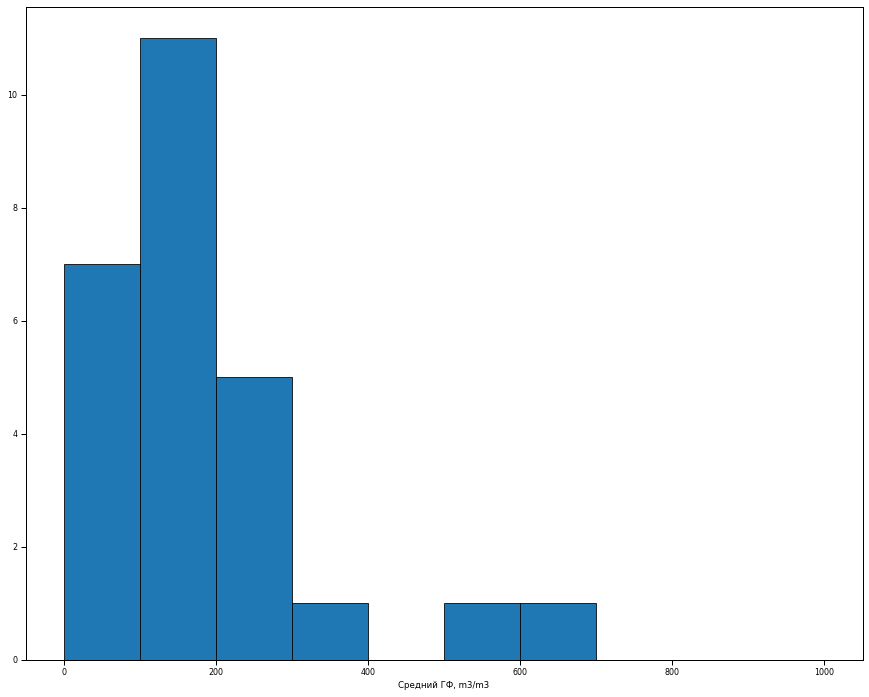

In [11]:
file_prod = 'Data\datos-de-fractura-de-pozos-de-hidrocarburos-adjunto-iv-actualizacin-diaria.csv'
file_comp = 'Data\produccin-de-pozos-de-gas-y-petrleo-no-convencional.csv'
wells = ADC_wells = [156968,
                    156967,
                    158754,
                    159379,
                    159136,
                    161421,
                    161364,
                    161365,
                    161366,
                    161721,
                    161722,
                    161720,
                    157567,
                    158178,
                    157733,
                    158177,
                    160885,
                    160886,
                    144107,
                    146887,
                    159464,
                    159463,
                    160537,
                    160536,
                    161522,
                    161223,
                    161577
                    ]

LL = 0
NS = 0

prod_analysis(file_prod, file_comp, wells, LL, NS)